<a href="https://colab.research.google.com/github/AurelioGuilherme/DNC_projetos/blob/main/Machine%20Learning/Regression_and_Clustering_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJETO DE CLUSTERIZAÇÃO E REGRESSÃO


## 1 - Importação de bibliotecas | Import libraries

In [199]:
# Data wrangling e data cleaning
import pandas as pd
import numpy as np

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

In [200]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='pastel',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

In [201]:
def valuesPlot(plot):
  for i in plot.patches:
    plot.annotate(i.get_height(),
                  (i.get_x() + i.get_width() / 2, i.get_height()),
                  ha='center',
                  va='baseline',
                  fontsize=12,
                  color='black',
                  xytext=(0, 1),
                  textcoords='offset points');

In [202]:
def outlier(df):
  ''' A função retornara os valores considerados outliers inferiores e superiores
    x = valor que deseja descobrir
    quartil_75 = retorna o quartil 75%
    quartil_25 = retorna o quartil 25%
    outlier é a diferença de 1,5 vezes a diferença do amplitude
    interquantil
    C = constante
      ''' 
  quartil_75 = np.quantile(df,0.75)
  quartil_25 = np.quantile(df,0.25)
  c = 1.5
  intervalo_Interquartil =  quartil_75 - quartil_25
  outlier_Sup = quartil_75 + (c * intervalo_Interquartil)
  outlier_Inf = quartil_25 - (c * intervalo_Interquartil)
  return outlier_Inf,outlier_Sup

## 2 - Contextualização


**Objetivo:** O projeto tem como propósito a criação de uma solução de Data Science para a empresa Acerola Segurity.SA (empresa fictícia) que atua no ramo de seguros. A empresa procurou-me pois quer entender, estudar e se possível melhorar seus preços dos seguros.

Também foi solicitado a análise da influência do sexo no custo do seguro, pois a empresa pretende incluir uma campanha direcionada ao público feminino e assim promover mais diversidade e acesso a este público

Inicialmente implementaremos um modelo não supervisionado de Clusterização para criar grupos e avaliar melhor os clientes, trazendo insights para o time de inovação da empresa.

Também implementaremos um modelo supervisionado de Machine Learning para prever os valores de seguro.

### Features iniciais | RAWDATA features

O conjunto de dados possui 1341 linhas e 7 colunas:

* idade: idade do cliente (min:18 / max: 64)
* Sexo: Variável categórica correspondente ao genero do cliente (Homem / mulher)
* imc: Índice de Massa Corpórea
* quantidade_filhos: Quantidade de filhos (min: 0 / max: 5)
* fumante: Variável categórica corresponde se o cliente é fumante (yes / no)
* regiao: Variável categorica correspondente a localidade onde o cliete reside.
* custos_seguro: Corresponde o custo do seguro do cliente

In [203]:
df = pd.read_excel('/content/insurance.xlsx')

In [204]:
df.head()

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.560,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3 - Data cleaning

In [205]:
df.shape

(1341, 7)

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              1341 non-null   int64  
 1   sexo               1338 non-null   object 
 2   imc                1341 non-null   float64
 3   quantidade_filhos  1341 non-null   int64  
 4   fumante            1341 non-null   object 
 5   regiao             1341 non-null   object 
 6   custos_seguro      1341 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.5+ KB


Alteração da tipagem dos dados para categorico das colunas idade, sexo, quantidade_filhos, fumante e região

In [207]:
df[[
    'idade',
    'sexo',
    'quantidade_filhos',
    'fumante',
    'regiao'
    ]] = \
df[[
    'idade',
    'sexo',
    'quantidade_filhos',
    'fumante',
    'regiao'
    ]].astype('category')

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   idade              1341 non-null   category
 1   sexo               1338 non-null   category
 2   imc                1341 non-null   float64 
 3   quantidade_filhos  1341 non-null   category
 4   fumante            1341 non-null   category
 5   regiao             1341 non-null   category
 6   custos_seguro      1341 non-null   float64 
dtypes: category(5), float64(2)
memory usage: 29.7 KB


### Identificando e removendo valores nulos.

Existem 3 valores nulos na coluna sexo.

In [209]:
df.isna()\
  .sum()

idade                0
sexo                 3
imc                  0
quantidade_filhos    0
fumante              0
regiao               0
custos_seguro        0
dtype: int64

Utilizando o metodo **query** indentificou-se os valores nulos, percebe-se que são valores idênticos e com custos de seguro igual a 0, portanto decidi por remove-los do conjunto de dados devido a serem valores incorretos que ocasionariam problemas com o modelo de regressão.

In [210]:
df.query('sexo != "male" & sexo !="female"')

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
1259,30,NaN,40.09,0,no,northeast,0.0
1285,30,NaN,40.09,0,no,northeast,0.0
1331,30,NaN,40.09,0,no,northeast,0.0


In [211]:
df.query('custos_seguro == 0')

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
1259,30,NaN,40.09,0,no,northeast,0.0
1285,30,NaN,40.09,0,no,northeast,0.0
1331,30,NaN,40.09,0,no,northeast,0.0


In [212]:
df = df.dropna()\
       .reset_index(drop=True)

### Identificando e removendo valores duplicados.

Existe somente um valor duplicado, porem para evitar problemas na etapa de modeling decidi por remove-lo previamente.

In [213]:
df.duplicated()\
  .sum()

1

In [214]:
df = df.drop_duplicates()\
       .reset_index(drop=True)

### Outliers

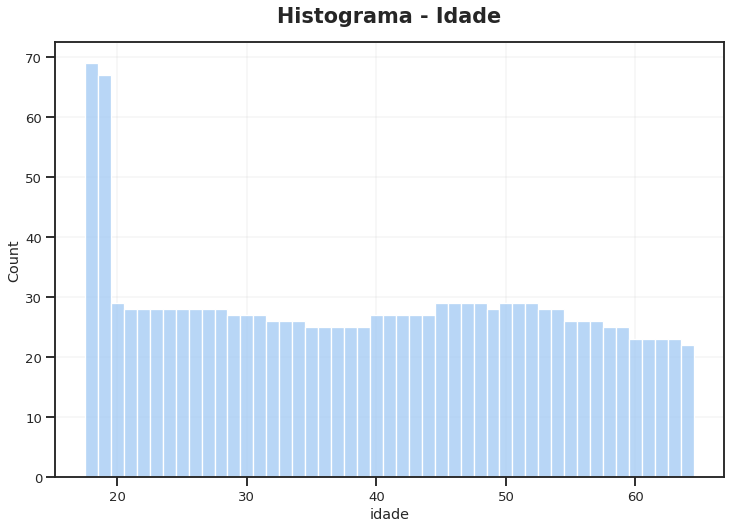

In [215]:
plot = sns.histplot(df.idade, bins = 16)\
          .set_title('Histograma - Idade')

Em idade os dados estão dentro da normalidade

- IMC

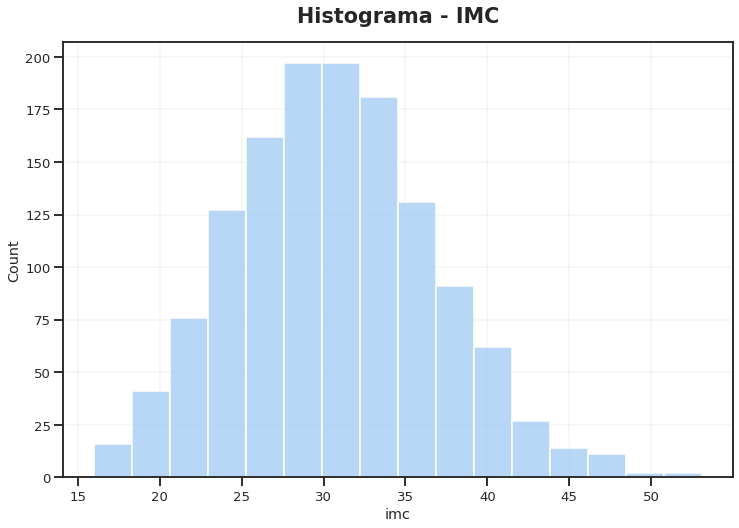

In [216]:
plot = sns.histplot(df.imc, bins = 16)\
          .set_title('Histograma - IMC')

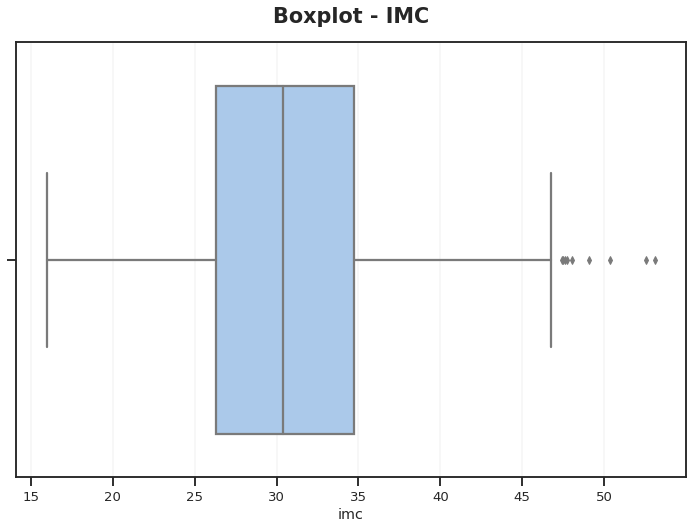

In [217]:
plot = sns.boxplot(data = df, x = df.imc)\
          .set_title('Boxplot - IMC')

Para identificar os valores outliers foi definida a função **outlier**, que recebe um objeto pandas.Series, no caso a coluna em que será identificado, e assim temos como retorno desta função os valores ouliers inferiores e superiores 

In [218]:
outlier_inf, outlier_sup = outlier(df.imc)

Utilizando a função **query** filtramos o dataframe mostrando somente os valores outliers 

In [219]:
df.query('imc >= @outlier_sup | imc <= @outlier_inf')

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
846,23,male,50.38,1,no,southeast,2438.05520
859,37,female,47.60,2,yes,southwest,46113.51100
1046,22,male,52.58,1,yes,southeast,44501.39820
1087,52,male,47.74,1,no,southeast,9748.91060
1316,18,male,53.13,0,no,southeast,1163.46270


Foi identificado 9 valores outliers em IMC, mas análisando os mesmos concluiu-se que os dados estão do padrão se tratando de IMC, portanto não será efetuado a remoção dos mesmos.

- Custos do seguro

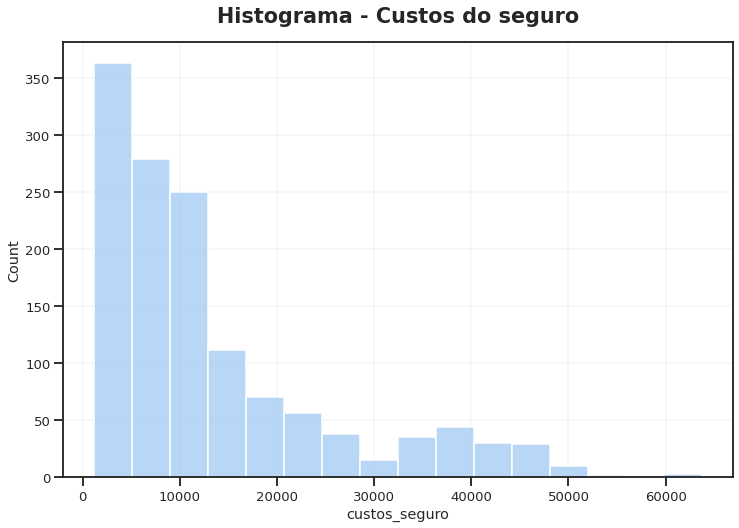

In [220]:
plot = sns.histplot(df.custos_seguro, bins = 16)\
          .set_title('Histograma - Custos do seguro')


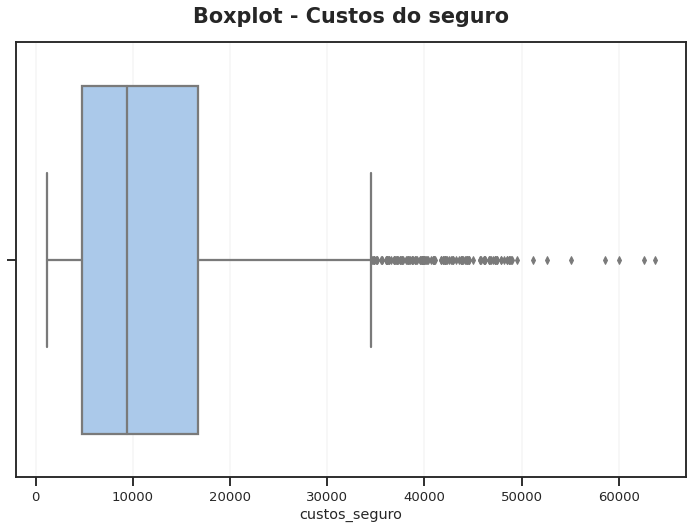

In [221]:
plot = sns.boxplot(data = df, x = df.custos_seguro)\
          .set_title('Boxplot - Custos do seguro')

In [222]:
outlier_inf, outlier_sup = outlier(df.custos_seguro)

In [223]:
df.query('custos_seguro >= @outlier_sup | custos_seguro <= @outlier_inf')  

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1299,45,male,30.360,0,yes,southeast,62592.87309
1300,62,male,30.875,3,yes,northwest,46718.16325
1302,43,male,27.800,0,yes,southwest,37829.72420
1312,19,female,34.700,2,yes,southwest,36397.57600


In [224]:
outlierDf = df.query('custos_seguro >= @outlier_sup | custos_seguro <= @outlier_inf' )

Utlizando a função **outlier** identificamos 139 valores outliers, cerca de 10,39% de nosso conjunto de dados, portanto será nessecario avaliar melhor esse grupo de dados indentificado como outliers

In [225]:
df.drop(df.query('custos_seguro >= @outlier_sup | custos_seguro <= @outlier_inf' ).index,axis = 0)

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.560,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


## 4 - EDA

In [226]:
df.describe()

,imc,custos_seguro
count,1337.000000,1337.000000
mean,30.663871,13279.121487
std,6.100648,12110.359656
min,15.960000,1121.873900
25%,26.290000,4746.344000
50%,30.400000,9386.161300
75%,34.700000,16657.717450
max,53.130000,63770.428010


### Análise gráfica 

- Idade

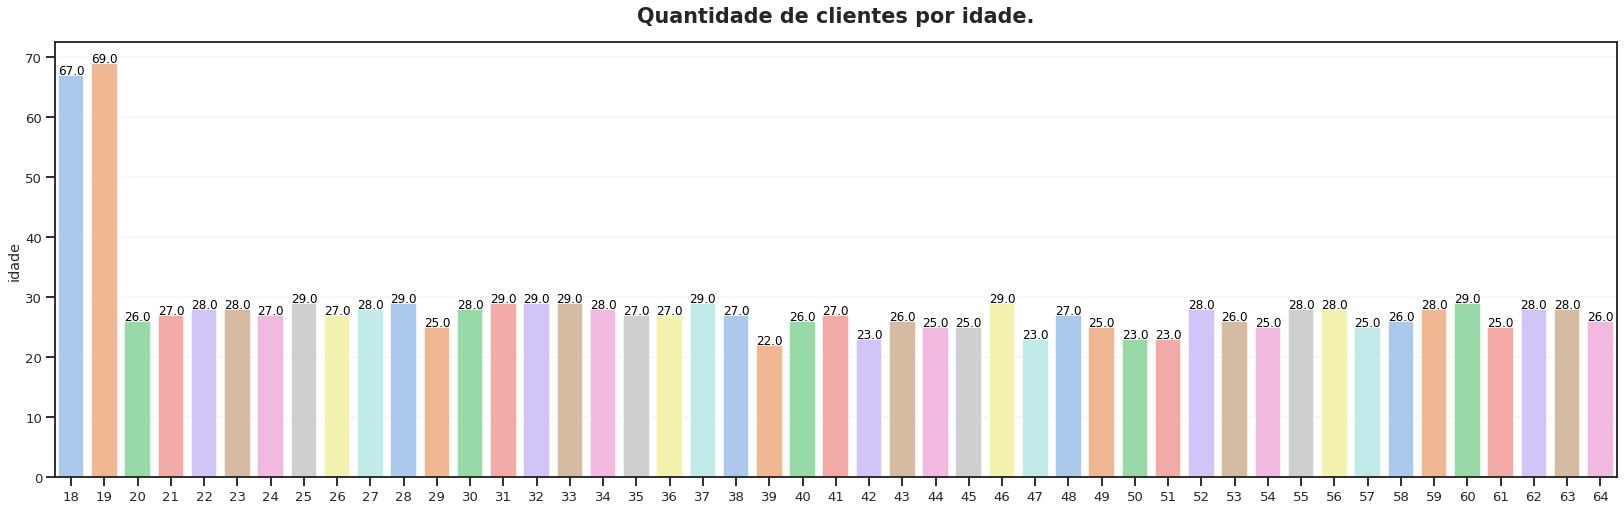

In [227]:
plt.figure(figsize=(28,8))
plt.title('Quantidade de clientes por idade.')
plot = sns.barplot(data = df, 
                   x=df.idade.unique(), 
                   y= df.idade.value_counts(), 
                   palette=("pastel"))
valuesPlot(plot)

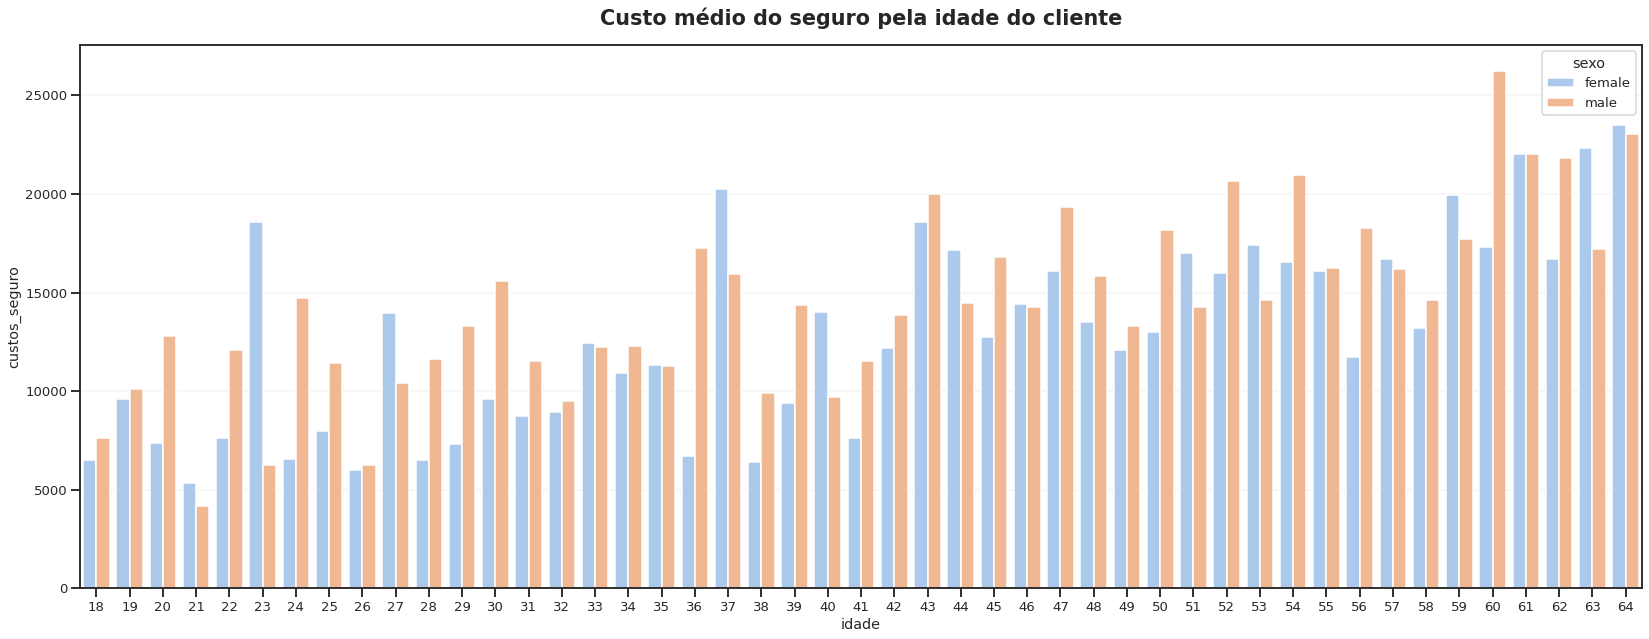

In [228]:
prov = df.groupby(['idade','sexo'])[['custos_seguro']]\
         .mean()\
         .round()\
         .reset_index()


plt.figure(figsize = (28,10))
plt.title('Custo médio do seguro pela idade do cliente')
sns.barplot(data = prov, 
            x = 'idade', 
            y = 'custos_seguro',
            hue = 'sexo'
            );

- Sexo

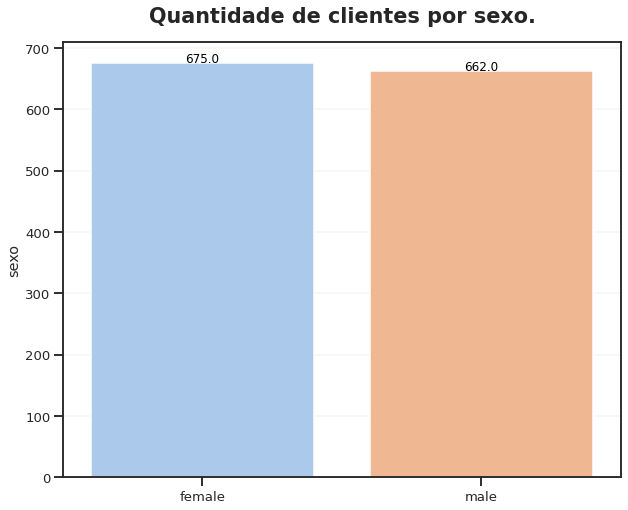

In [229]:
plt.figure(figsize=(10,8))
plt.title('Quantidade de clientes por sexo.')
plot = sns.barplot(data = df, x=df.sexo.unique(), y= df.sexo.value_counts(), palette=("pastel"))
valuesPlot(plot)

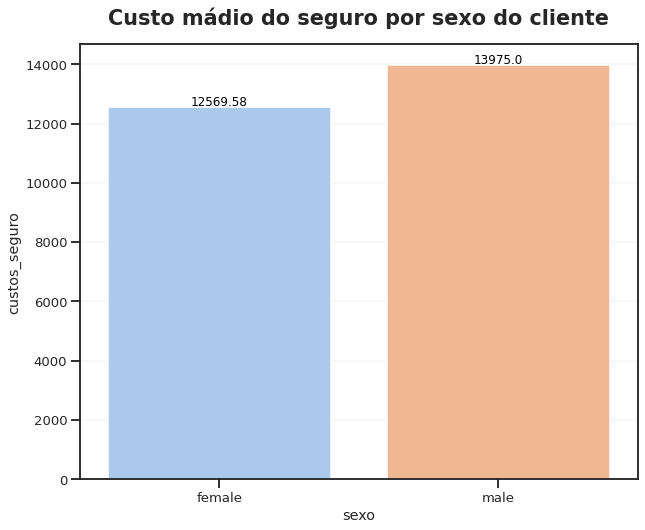

In [230]:
prov = df.groupby('sexo')[['custos_seguro']]\
         .mean()\
         .round(2)\
         .reset_index()
         
plt.figure(figsize = (10,8))
plt.title('Custo mádio do seguro por sexo do cliente')
plot = sns.barplot(data = prov, 
                   x = 'sexo', 
                   y ='custos_seguro')
valuesPlot(plot)

- Fumante

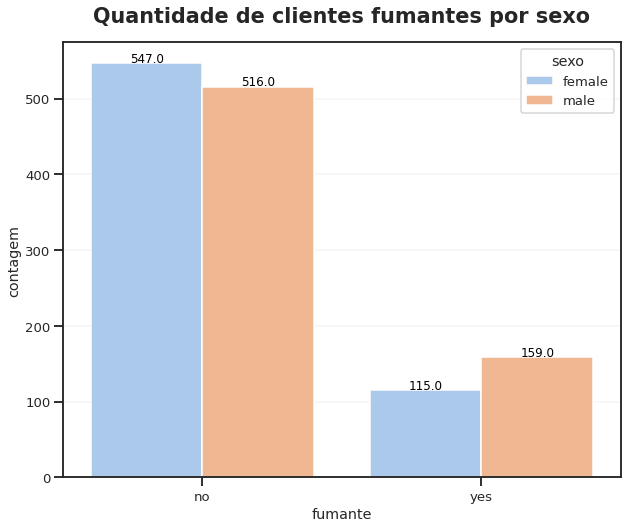

In [231]:
prov = df.groupby(['fumante', 'sexo'])[['fumante']]\
         .count()\
         .rename(columns = {'fumante': 'contagem'})\
         .reset_index()
  

plt.figure(figsize=(10,8))

plt.title('Quantidade de clientes fumantes por sexo')
plot = sns.barplot(data = prov,
                   x= 'fumante', 
                   y= 'contagem', 
                   hue = 'sexo',
                   palette=("pastel"))
valuesPlot(plot)

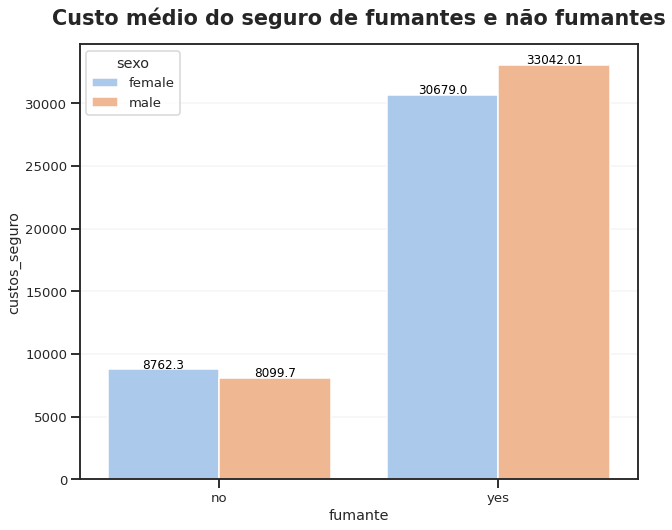

In [232]:
prov = df.groupby(['fumante','sexo'])[['custos_seguro']]\
         .mean()\
         .round(2)\
         .reset_index()

plt.figure(figsize = (10,8))
plt.title('Custo médio do seguro de fumantes e não fumantes')
plot = sns.barplot(data = prov, 
             x = 'fumante', 
             y = 'custos_seguro',
             hue = 'sexo');
valuesPlot(plot)

- Filhos

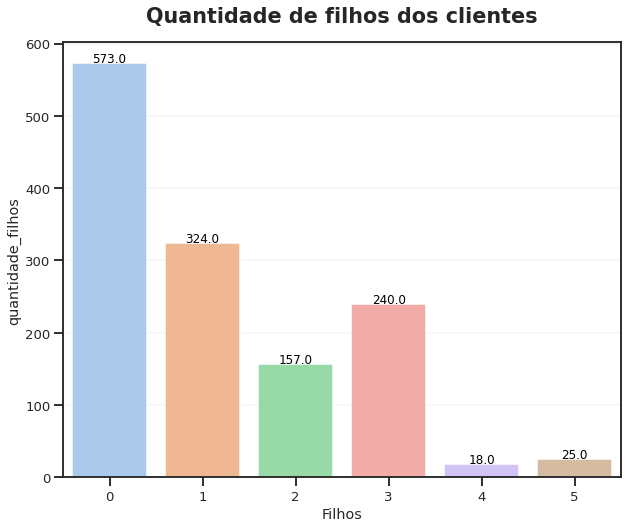

In [233]:
plt.figure(figsize=(10,8))
plt.title('Quantidade de filhos dos clientes')
plot = sns.barplot(data = df, 
                   x=df.quantidade_filhos.unique(), 
                   y= df.quantidade_filhos.value_counts(), 
                   palette=("pastel"))
plt.xlabel('Filhos')
valuesPlot(plot)

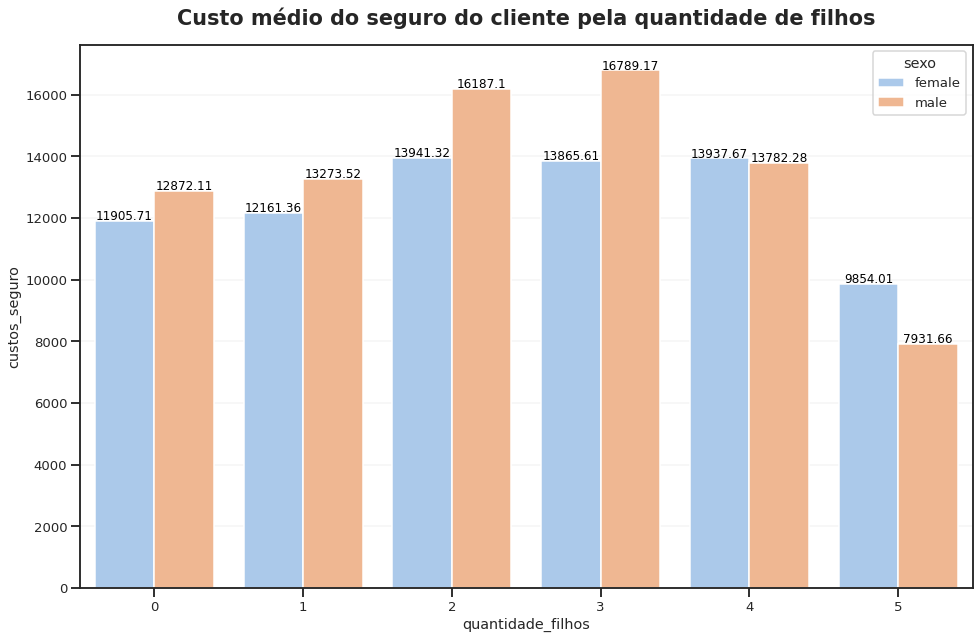

In [261]:
prov = df.groupby(['quantidade_filhos', 'sexo'])[['custos_seguro']]\
         .mean()\
         .round(2)\
         .reset_index()

plt.figure(figsize = (16,10))         
plt.title('Custo médio do seguro do cliente pela quantidade de filhos')         
plot = sns.barplot(data = prov,
                    x = 'quantidade_filhos', 
                    y = 'custos_seguro',
                    hue = 'sexo');
valuesPlot(plot)



- Região

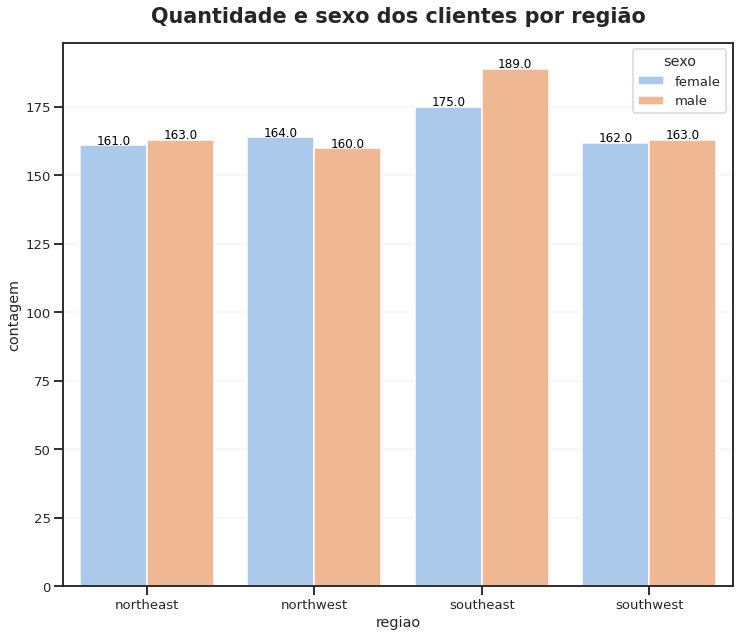

In [235]:
prov = df.groupby(['regiao','sexo'])[['sexo']].count()\
         .rename(columns = {'sexo': 'contagem'})\
         .reset_index()

plt.figure(figsize=(12,10))
plt.title('Quantidade e sexo dos clientes por região')
plot = sns.barplot(data = prov, 
                   x='regiao', 
                   y= 'contagem', 
                   hue = 'sexo',
                   palette=("pastel"))
valuesPlot(plot)


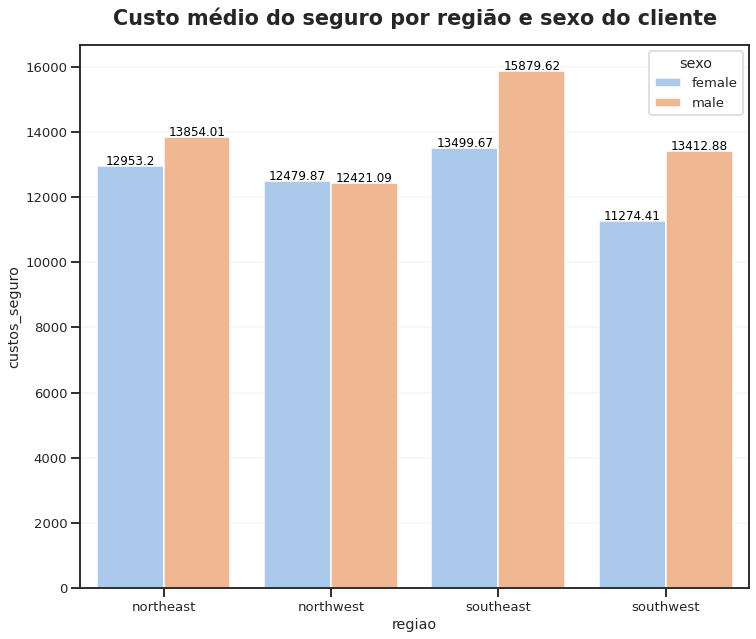

In [236]:
prov = df.groupby(['regiao','sexo'])[['custos_seguro']]\
         .mean()\
         .round(2)\
         .reset_index()
         
plt.figure(figsize = (12,10))
plt.title("Custo médio do seguro por região e sexo do cliente")
plot = sns.barplot(data = prov, 
                   x = 'regiao', 
                   y = 'custos_seguro',
                   hue = 'sexo');
valuesPlot(plot)

- IMC

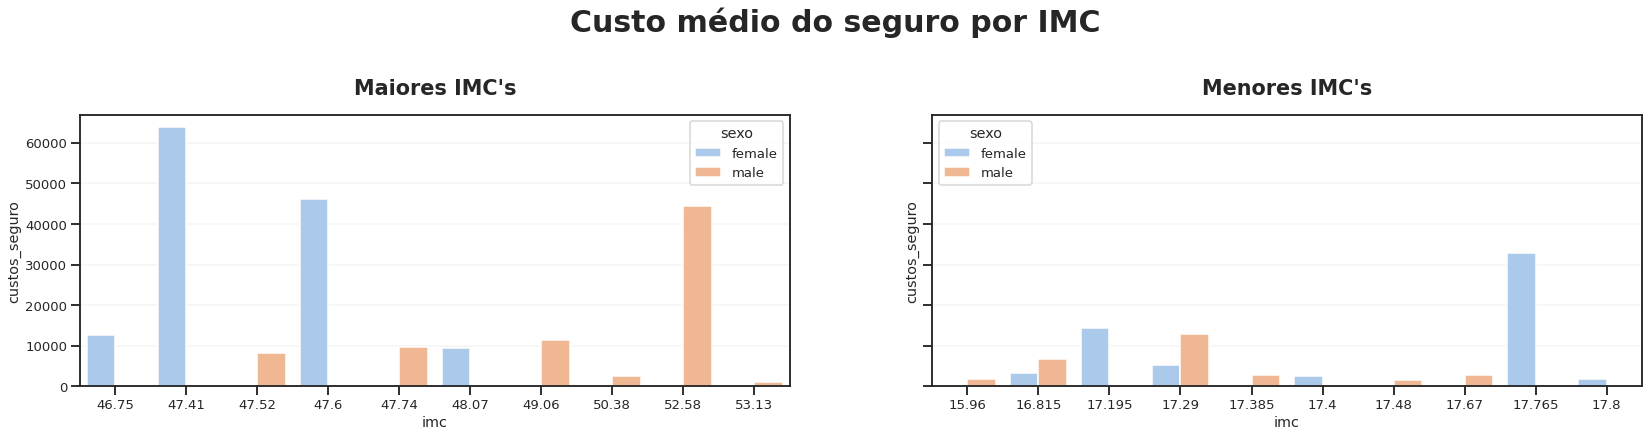

In [237]:
prov = df.groupby(['imc','sexo'])[['custos_seguro']]\
         .mean()\
         .reset_index()\
         .sort_values(by = 'imc', ascending = False)         
      
fig, axes = plt.subplots(1, 2, figsize=(28, 5), sharey=True)
fig.suptitle('Custo médio do seguro por IMC', 
             fontsize = 30,
             fontweight='bold')\
             .set_y(1.18)
             

# Plot 1
plot = sns.barplot(ax=axes[0],
                   data = prov.head(20),
                   x = 'imc',
                   y = 'custos_seguro',
                   hue = 'sexo')
axes[0].set_title("Maiores IMC's")

#Plot 2
plot2 = sns.barplot(ax=axes[1],
                   data = prov.tail(20),
                   x = 'imc',
                   y = 'custos_seguro',
                   hue = 'sexo')
axes[1].set_title("Menores IMC's")
plt.show()

In [258]:
df['faixa_etaria'] = df['idade'].apply(lambda x : 'jovem' if x < 25 else 
                                                 'adulto' if x <= 59 else
                                                  'idoso' if x > 59 else x)\
                                                  .astype('category')
                             

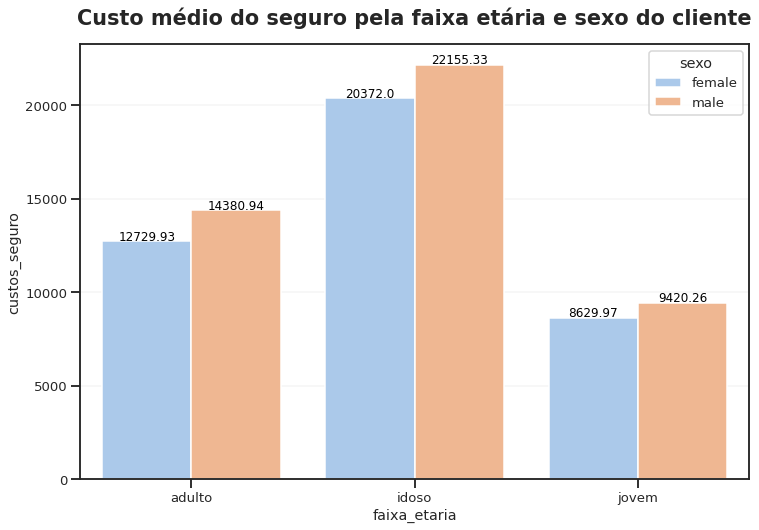

In [281]:
prov = df.groupby(['faixa_etaria','sexo'])[['custos_seguro']]\
         .mean()\
         .round(2)\
         .reset_index()
         
plt.figure(figsize = (12,8))
plt.title("Custo médio do seguro pela faixa etária e sexo do cliente")
plot = sns.barplot(data = prov, 
                   x = 'faixa_etaria', 
                   y = 'custos_seguro',
                   hue = 'sexo');
valuesPlot(plot)

In [286]:
df['classe_IMC'] = df['imc'].apply(lambda x : 'Desnutrido' if x < 18.5 else 
                                                  'normal' if x < 25 else 
                                                 'sobpeso' if x < 30 else
                                             'obesidade_I' if x < 35 else 
                                            'obesidade_II' if x < 40 else
                                            'obsidade_III' if x >= 40 else x)\
                                            .astype('category')

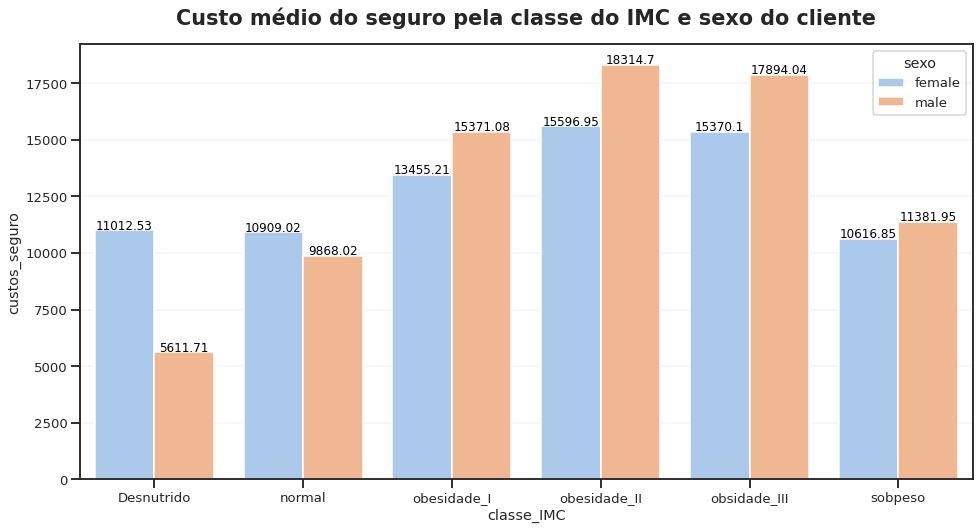

In [282]:
prov = df.groupby(['classe_IMC','sexo'])[['custos_seguro']]\
         .mean()\
         .round(2)\
         .reset_index()
         
plt.figure(figsize = (16,8))
plt.title("Custo médio do seguro pela classe do IMC e sexo do cliente")
plot = sns.barplot(data = prov, 
                   x = 'classe_IMC', 
                   y = 'custos_seguro',
                   hue = 'sexo');
valuesPlot(plot)

##5 Cluster

https://www.kaggle.com/code/rohanadagouda/unsupervised-learning-using-k-prototype-and-dbscan

https://antonsruberts.github.io/kproto-audience/

In [318]:
!pip install kmodes -q

In [319]:
from sklearn.preprocessing import PowerTransformer
from kmodes.kprototypes import KPrototypes

In [363]:
df_cluster = df.copy()

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro,faixa_etaria,classe_IMC
0,19,female,27.900,0,yes,southwest,16884.92400,jovem,sobpeso
1,18,male,33.770,1,no,southeast,1725.55230,jovem,obesidade_I
2,28,male,33.560,3,no,southeast,4449.46200,adulto,obesidade_I
3,33,male,22.705,0,no,northwest,21984.47061,adulto,normal
4,32,male,28.880,0,no,northwest,3866.85520,adulto,sobpeso
...,...,...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830,adulto,obesidade_I
1333,18,female,31.920,0,no,northeast,2205.98080,jovem,obesidade_I
1334,18,female,36.850,0,no,southeast,1629.83350,jovem,obesidade_II
1335,21,female,25.800,0,no,southwest,2007.94500,jovem,sobpeso


In [371]:
df_cluster['sexo'] = df_cluster['sexo'].replace(['female',
                                                 'male'], 
                                                   [0,1]).astype('object')

df_cluster['fumante'] = df_cluster['fumante'].replace(['no',
                                                       'yes'], 
                                                        [0,1]).astype('object')

df_cluster['regiao'] = df_cluster['regiao'].replace(['northeast',
                                                     'northwest',
                                                     'southeast',
                                                     'southwest'], 
                                                        [0,1,2,3]).astype('object')

df_cluster['faixa_etaria'] = df_cluster['faixa_etaria'].replace(['jovem',
                                                                 'adulto',
                                                                 'idoso'], 
                                                                  [0,1,2]).astype('object')

df_cluster['classe_IMC'] = df_cluster['classe_IMC'].replace(['sobpeso',
                                                             'obesidade_I',
                                                             'normal',
                                                             'obesidade_II',
                                                             'obsidade_III',
                                                             'Desnutrido'], 
                                                             [0,1,2,3,4,5]).astype('object')

In [365]:
for c in df.select_dtypes(exclude='category').columns:
    pt = PowerTransformer()
    df_cluster[c] =  pt.fit_transform(np.array(df_cluster[c]).reshape(-1, 1))

categorical_columns = [0,1,3,4,5,7,8]

In [375]:
kproto = KPrototypes(n_clusters= 5, 
                     init='Cao', 
                     n_jobs = -1)
clusters = kproto.fit_predict(df_cluster, 
                              categorical=categorical_columns)

In [376]:
df_cluster['cluster'] = clusters

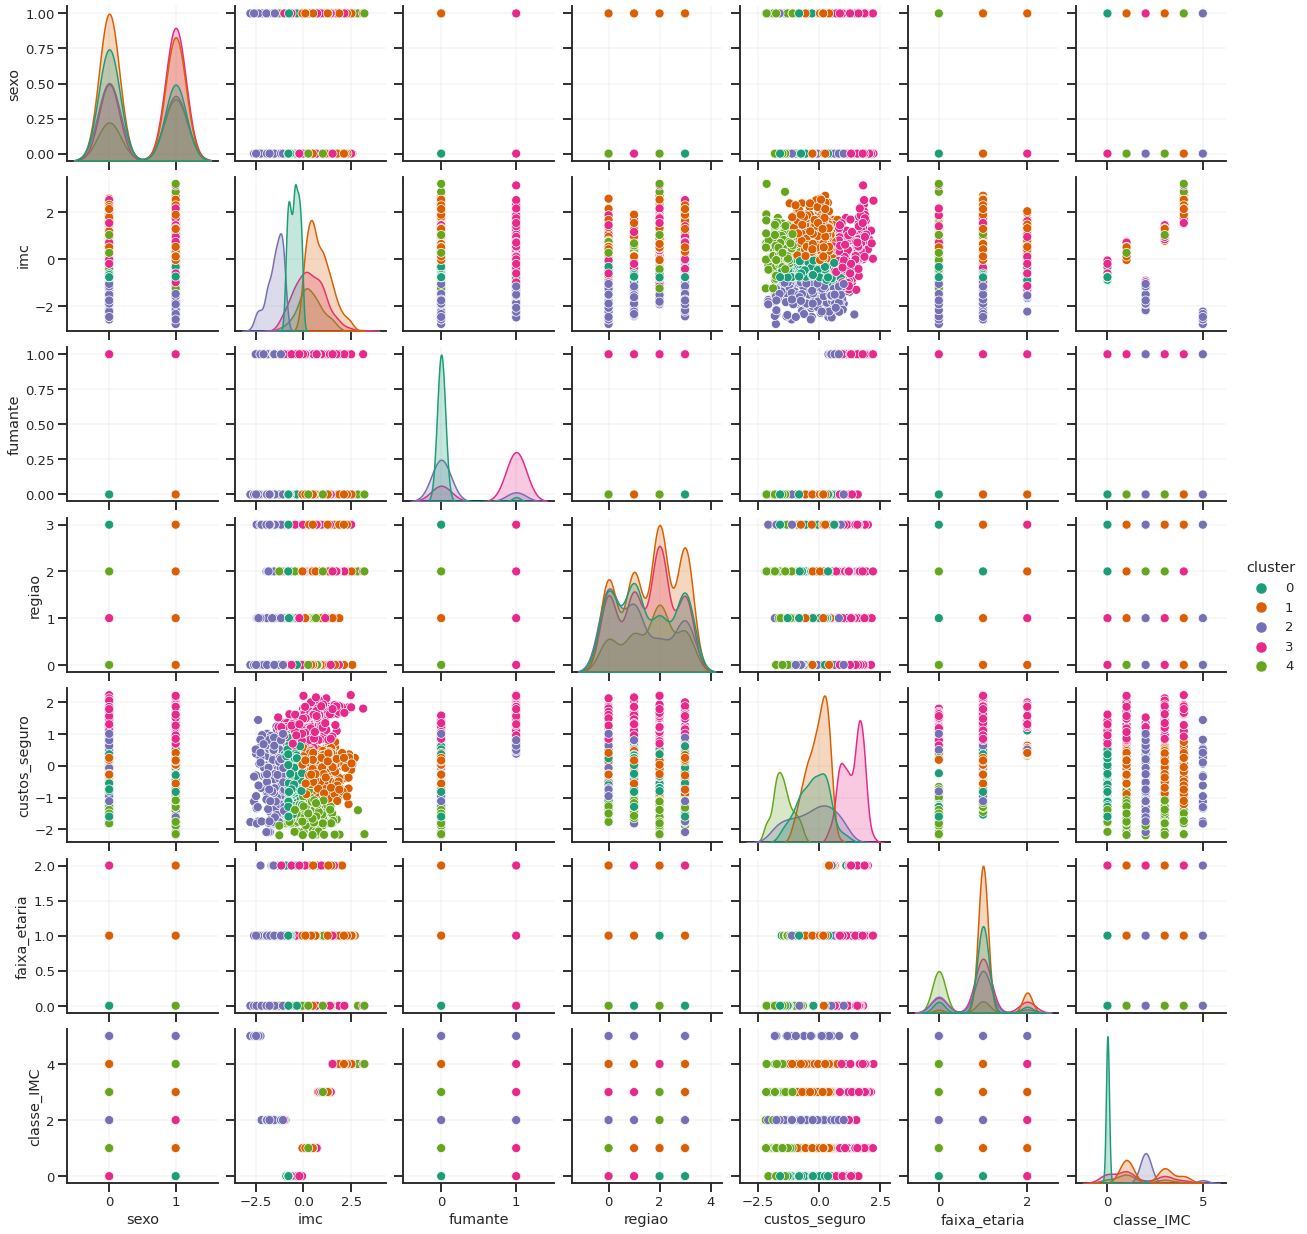

In [377]:
ax = sns.pairplot(data=df_cluster,
                  hue='cluster', 
                  palette='Dark2',
                  diag_kind='kde')